# Description
This notebook attempts to answer the question:
"What are the estimated smoke impacts on Leavenworth, Kansas for the last 60 years."

In this notebook, multiple main actions are done:
1. Read wildfire GEOJson data
2. Calculate distance from all wildfires to Leavenworth, Kansas by averaging ring distance.
3. Save immediate results to new file
4. Get the subset of all fires with in 1250 miles of Leavenworth, Kansas
5. Create an annual smoke estimate
6. Get monthly AQI estimates for Leavenworth Kansas by combining the nearest four station particulate data. 
7. Create linear regression model to predict the annual smoke estimate, and create ARIMA model to forecast the annual smoke estimate to 2049.
8. Create histogram visualization showing the number of fires occuring every 50 miles from Leavenworth up to 1250 miles.
9. Create time series showing annual acres burned by wildfires with in 1250 miles of Leavenworth.
10. Create time series showing smoke estimate, create time series showing AQI estimate. 

Warnings:
1. Since file sizes are ~3gb, you may run out of memory, especially if you have many duplicates of the same data. This is why we attempt to clear up memory at times.  


# Imports

In [41]:
import os, json, time, sys
from wildfire.Reader import Reader
import geojson
import requests
import pyproj
import math
import numpy as np
import datetime as dt
#from statsmodels.tsa.arima_model import ARIMA
#import statsmodels.api as sm
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels
import statsmodels.api as sm

# 1. Read wildfire GEOJson data

### Load GEOJSON file reader

NOTE: 
```
The WFReader module was created by David W. McDonald.
REVISION: August, 2023
CREATION DATE: August, 2023
Author: David W. McDonald
A simple streaming reader/loader that is designed to load GeoJSON files. This class is part of the wildfire user module.
Copyright by Author. All rights reserved. Not for reuse without express permissions.
```
DATA: 
https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81  
Documentation:
https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0%2F63%2F53%2Fd063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true 

In [2]:
data_filepath = "./../Data/USGS_Wildland_Fire_Combined_Dataset.json"
geojson_file = open(data_filepath,"r")
gj_data = geojson.load(geojson_file)
geojson_file.close()
wfreader = WFReader(data_filepath)

### Get fire data into list of dictionaries

In [3]:
#We know this is how many features are in the dataset, this should be changed for other datasets
MAX_FEATURE_LOAD = 135061
feature_list = list()
feature_count = 0

# A rewind() on the reader object makes sure we're at the start of the feature list
wfreader.rewind()

# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
for i in tqdm(range(135061), position=0, leave=True):
    feature_list.append(feature)
    feature_count += 1
    feature = wfreader.next()
print(f"Loaded a total of {feature_count} features")

100%|███████████████████████████████████████████████████████████████████████| 135061/135061 [10:00<00:00, 225.03it/s]

Loaded a total of 135061 features


# 2. Calculate distance from all wildfires to Leavenworth, Kansas by averaging ring distance.
### For each fire calculate average ring distance from Leavenworth Kansas

In [19]:
def convert_ring_to_epsg4326(ring_data=None):
    # Description:
    #    Converts a list of ESRI:102008 coordinates to EPSG:4326 coordinates
    # Inputs:
    #    ring_data - List of ESRI:102008 coordinates that will be transformed to EPSG:4326
    # Output:
    #    List of coordinates in EPSG:4326
    
    converted_coords = list()

    # Use pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")

    # Transform each ESRI:102008 (x,y) coord into a decimal degree (lat,lon)
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_coords.append(new_coord)
    return converted_coords

def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # Description:
    #    Calculates the average miles from a list of coordinates to target coordinates
    # Inputs:
    #    place - list or tuple with 2 items (lat,lon) in decimal degrees EPSG:4326
    #    ring_data - List of decimal degree coordinates
    # Output:
    #    Average miles from ring_data coordinates to the target coordinates
    # Notes:
    #    Modification of function created by David W. McDonald.
    #    This code was developed by David W. McDonald for use in Data 512,
    #    a course in the UW MS Data Science degree program. This code is 
    #    provided under the Createive Commons CC-BY license. Revision 1.0 - 
    #    August 13, 2023.
    
    # Convert the ring data from ESRI:102008 coordinates to EPSG:4326 coordinates
    ring = convert_ring_to_epsg4326(ring_data)    
    
    # Create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    
    # Get list of meter distances between each point coordinates and the target coordinates
    distances_in_meters = list()
    for point in ring:
        d = geodcalc.inv(place[1],place[0],point[1],point[0]) #Distance calculation
        distances_in_meters.append(d[2])
        
    # Convert list of meter distances to list of mile distances
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    
    # The esri polygon shape (the ring) requires that the first and last coordinates 
    # be identical to 'close the region. We remove one of them so that we don't bias 
    # our average by having two of the same point.
    distances_in_miles_no_dup = distances_in_miles[1:]
    
    # Get the average of miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

def calculate_fire_distances(geojson_data, coords):
    """
    Description:
       Given list of dictionaries of wildfire data, add a new field 
       called 'distance_from_Leavenworth", to each dictionary that is 
       the average distance between the coordinates of Leavenworth, Kansas
       and the polygon coordinate points of the wildfire. If a wildfire doesn't 
       have any coordinates associated with it, we will remove it from the argument
       dictionary.
    Inputs:
        geojson_data - List of dictionaries
        coords - Tuple of lat,lon WSG84 coordinates (float)
    Output:
        List of dictionary items that were removed because a distance could not be calculated
    """
    log_deleted_entries = []
    for i in tqdm(range(len(geojson_data)), position=0, leave=True):
        #Get dictionary
        wf_feature = geojson_data[i]
        
        #Delete and log entries where distance cannot be calculated due to missing
        #coordinate information. 
        if('rings' not in wf_feature['geometry'].keys()):
            log_deleted_entries.append(wf_feature)
            del wf_feature
            continue
            
        #Calculate distance and create a new key value pair in the dictionary
        ring_data = wf_feature['geometry']['rings'][0]
        distance = average_distance_from_place_to_fire_perimeter(coords, ring_data)
        wf_feature['distance_from_Leavenworth'] = distance
    
    #Return all deleted dictionaries
    return log_deleted_entries

CITY_COORDS = (39.313015, -94.941147) #LAT, LON in EPSG:4326/WSG84
deleted_entries = calculate_fire_distances(feature_list, CITY_COORDS)
print("There were ", len(deleted_entries), " removed entries that could not have distance calculated.")

100%|██████████████████████████████████████████████████████████████████████| 135061/135061 [3:50:15<00:00,  9.78it/s]

There were  35  removed entries that could not have distance calculated.


# 3. Save immediate results to new file
The reason we are doing this is because it takes 2-3 hours at a minimum to re-calculate distances.

In [23]:
#Save these distances to a new file so we don't have to redo the calculations
with open('./../Data/USGS_Wildland_Fire_Combined_WithDistances.json', 'w') as f:
    json.dump({"data": feature_list}, f)

# 4. Get the subset of all fires with in 1250 miles of Leavenworth, Kansas

### Load in data from new file 
This is so you can rerun the notebook and skip the step that takes a really long time.  
Additionally, clear the old data if it is still there. 

In [24]:
# Read in file, and clear out old information to save on space
del feature_list
del gj_data
with open('./../Data/USGS_Wildland_Fire_Combined_WithDistances.json') as f:
    wildfire_data = json.load(f)["data"]

In [27]:
def get_fires_in_distance(geojson_data, miles):
    """
    Description:
        Given list of dictionaries of wildfire data, return all fires that meet
        the condition that their distance_from_Leavenworth attribute is less than
        the input argument 'miles'.
    Input:
        geojson_data = List of dictionaries
        miles - Float/Integer
    Output:
        List of dictionaries (Subset of input argument)
    """
    fires_in_distance = []
    for i in range(len(geojson_data)):
        try:
            wf_feature = geojson_data[i]
            wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
            wf_year = wf_feature['attributes']['Fire_Year']
            ring_data = wf_feature['geometry']['rings'][0]
            wf_size = wf_feature['attributes']['GIS_Acres']
            wf_type = wf_feature['attributes']['Assigned_Fire_Type']
            distance = wf_feature['distance_from_Leavenworth']
            #print(distance)
            if(distance <= 1250):
                fires_in_distance.append(wf_feature)
                #print(wf_name, distance)
        except:
            print("No data for", wf_feature['attributes']['Listed_Fire_Names'].split(',')[0])
    return fires_in_distance

city_fires = get_fires_in_distance(wildfire_data, 1250)
print("There are a total of", len(city_fires), "within 1250 miles of leavenworth, kansas",)

No data for BARNES SOUTH UNDERBURN - BARNES SOUTH  UNDERBURN (1)
No data for BOYD JOHNSON (1)
No data for VIRGINIAS (3)
No data for GEORGE BRAND (1)
No data for HOMOCHITTO BURN BLOCK 36 (1)
No data for VIRGINIAS (2)
No data for JAMIE JORDON (1)
No data for JIM TIMBERLAKE (1)
No data for No Fire Name Provided (1)
No data for WILLIAM GHOLSTON (1)
No data for JOHN HUTCHESON (1)
No data for JEAN DODSON (1)
No data for KEITH O'DANIEL (1)
No data for MICHAEL CROWE (1)
No data for JEANETTE WALKER (1)
No data for No Fire Name Provided (2)
No data for No Fire Name Provided (1)
No data for Little Bald Hills - Williams Ridge Rx (2)
No data for BALANCE UNDERBURN UNIT 2-1 (1)
No data for MYRTLE BB WUI FY 15 (1)
No data for RICHARDS
No data for DELTA BLOCK 1 (1)
No data for JIM BETHEL GFC (1)
No data for INTERDISCIPLINARY UNIT LBJ 41 - PATCH BURN UNIT A (HOPWELL CHURCH) (1)
No data for 2_HL_MRA Administrative Tumbleweeds 5 (1)
No data for FULTON (1)
No data for MYRTLE BB FY 17 (1)
No data for No Fir

### Show example data

In [29]:
print(json.dumps(wildfire_data[0],indent=2))

{
  "attributes": {
    "OBJECTID": 1,
    "USGS_Assigned_ID": 1,
    "Assigned_Fire_Type": "Wildfire",
    "Fire_Year": 1860,
    "Fire_Polygon_Tier": 1,
    "Fire_Attribute_Tiers": "1 (1)",
    "GIS_Acres": 3940.20708940724,
    "GIS_Hectares": 1594.5452365353703,
    "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
    "Listed_Fire_Types": "Wildfire (1)",
    "Listed_Fire_Names": "Big Quilcene River (1)",
    "Listed_Fire_Codes": "No code provided (1)",
    "Listed_Fire_IDs": "",
    "Listed_Fire_IRWIN_IDs": "",
    "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
    "Listed_Fire_Causes": "",
    "Listed_Fire_Cause_Class": "Undetermined (1)",
    "Listed_Rx_Reported_Acres": null,
    "Listed_Map_Digitize_Methods": "Other (1)",
    "Listed_Notes": "",
    "Processing_Notes": "",
    "Wildfire_Notice": "Wildfire mapping prior to 1984 was inconsistent, infrequent, and done without the aid of more modern fire mapping

### Put fires into dictionary grouped by "Fire_Year"

In [30]:
fires_grouped_by_year = {}
for fire in wildfire_data:
    year = str(fire["attributes"]["Fire_Year"])
    if(year not in fires_grouped_by_year.keys()):
        fires_grouped_by_year[year] = []
        fires_grouped_by_year[year].append(fire)
    else:
        fires_grouped_by_year[year].append(fire)

# 5. Create an annual smoke estimate
The estimate for annual smoke that I came up with is very simple. 
In this estimate I try to incorporate the volume of smoke burned by wood, the amount of 
wood burned, and the distance from the wildfire to Leavenworth. 
Unfortunately, this estimate is probably very inaccurate.

Formula: Smoke_impact_from_fire = (area_forest_burned * 10 * 87.5) / (distance_from_city^5)
To get the annual smoke estimate, we sum the smoke_impact_from_fire over every fire.

Assumptions made:
1. The volume of smoke produced by wood is 87.5 M^2 per kg. 
http://virtual.vtt.fi/virtual/innofirewood/stateoftheart/database/burning/burning.html#:~:text=In%20well%20ventilated%20conditions%2C%20the,the%20smoke%20production%20of%20wood.  
2. There is 10 kilograms of wood on average per square meter in a forest. (No source)
3. Smoke dispersion is inversely proportional to the distance to the fifth power. (Did this to keep relative scale low)

Reasons this estimate is bad:
1. The volume of smoke produced by wood depends on the type of tree.
2. More than just wood burns in a wildfire. 
3. The amount of wood on average per square meter in a forest varies on the type of flora present, the season, and other various factors.
4. Smoke dispersion is much more complicated than what I have proposed. There have been many studies on atmospheric transport models, which are much better estimates than what we have. However data for atmospheric transport models probably does not exist for our data (especially for the old stuff). 
5. Other factors that I'm not aware of

###### Notes:  
Overall, I decided the smoke estimate should be summed during the year because data is sparse. This means if we were to use a finer time scale we would end up with a lot of missing data that we would either have to set as an average or 0 in order to do time-series analysis. 

I did not see a reason to only use wildfires from the fire season, as smoke can effect a city at any time of the year. 

I looked for sources talking about the amount of wood per square meter in a forest but could not find anything. Therefore I arbitrarily picked a number, as the amount of smoke would scale linearly, so in terms of tracking relative change it wouldn't affect much. 

In [31]:
annual_smoke_estimates = {}
start_year = 1963
end_year = 2023

for year in range(1963, 2023):
    total_smoke_volume_estimate = 0
    if(str(year) not in fires_grouped_by_year.keys()):
        annual_smoke_estimates[str(year)] = {"total_smoke_volume_estimate": 0}
        continue
    for fire in fires_grouped_by_year[str(year)]:
        try:
            area_of_forest_burned = fire["attributes"]["Shape_Area"] #Square meters
            distance_from_leavenworth = fire["distance_from_Leavenworth"]
            if(distance_from_leavenworth > 1250):
                continue
        
            #Making bad assumption that there is 10kg of wood on average per square meter in a forest
            wood_burned_estimate = area_of_forest_burned * 10 #In Kilograms
            
            #Assumption from source above to calculate smoke volume from burning wood
            smoke_volume_estimate = wood_burned_estimate * 87.5 #Meters squared
        
            #Making bad assumption that smoke dispersion is inversely proportion to the exponential of distance
            smoke_volume_estimate = smoke_volume_estimate / (int(distance_from_leavenworth)**5)
            total_smoke_volume_estimate += smoke_volume_estimate
            annual_smoke_estimates[str(year)] = {
                "total_smoke_volume_estimate": total_smoke_volume_estimate
            }
        except:
            print("Skipped over", fire['attributes']['Listed_Fire_Names'].split(',')[0])

print(annual_smoke_estimates)
# Summation
# Volume of wood burned * volume of smoke produced by burning X volume of wood
# / distance from city
# Divide by N
# Divide by max
# Multiply by 500

Skipped over BARNES SOUTH UNDERBURN - BARNES SOUTH  UNDERBURN (1)
Skipped over BOYD JOHNSON (1)
Skipped over VIRGINIAS (3)
Skipped over GEORGE BRAND (1)
Skipped over HOMOCHITTO BURN BLOCK 36 (1)
Skipped over VIRGINIAS (2)
Skipped over JAMIE JORDON (1)
Skipped over JIM TIMBERLAKE (1)
Skipped over No Fire Name Provided (1)
Skipped over WILLIAM GHOLSTON (1)
Skipped over JOHN HUTCHESON (1)
Skipped over JEAN DODSON (1)
Skipped over KEITH O'DANIEL (1)
Skipped over MICHAEL CROWE (1)
Skipped over JEANETTE WALKER (1)
Skipped over No Fire Name Provided (2)
Skipped over No Fire Name Provided (1)
Skipped over Little Bald Hills - Williams Ridge Rx (2)
Skipped over BALANCE UNDERBURN UNIT 2-1 (1)
Skipped over MYRTLE BB WUI FY 15 (1)
Skipped over RICHARDS
Skipped over DELTA BLOCK 1 (1)
Skipped over JIM BETHEL GFC (1)
Skipped over INTERDISCIPLINARY UNIT LBJ 41 - PATCH BURN UNIT A (HOPWELL CHURCH) (1)
Skipped over 2_HL_MRA Administrative Tumbleweeds 5 (1)
Skipped over FULTON (1)
Skipped over MYRTLE BB F

# 6. Get monthly AQI estimates for Leavenworth Kansas by combining the nearest four station particulate data.

What is AQI?
https://ecology.wa.gov/Research-Data/Monitoring-assessment/Air-Quality-Index  
AQI stands for Air Quality Index, which is just a number from 0-500(?) that quantifies how hazardous
the air currently is. AQI measures carbon monoxide, nitrogren dioxide, ozone health, particle pollution, and sulfur dioxide. 

In this work, since we are dealing with wildfire data, we only will consider particulates when dealing with AQI. More specifically, we will only include data that measures PM10 and PM2.5 which respectively measure particles less than 10 micrometers and particles less than 2.5 micrometers in size (diameter?).

This code was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023

Documentation for the AQS API can be found here: https://aqs.epa.gov/aqsweb/documents/data_api.html

#### Constants

In [32]:
#Below is all of the different constants needed to make use of the AQS API
USERNAME = "zbowyer@uw.edu"
APIKEY = "tealmallard53"  #I know this is bad but there's nothing at stake here

#Request API Key constants
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
API_ACTION_SIGNUP = '/signup?email=zbowyer@uw.edu'

# List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

# Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

# Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

# Assuming roughly 2ms latency on the API and network
API_LATENCY_ASSUMED = 0.002 
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

# Parameter list or 'param' value as defined by the AQS API spec.
# It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
# all seven of the code types. We can only have a max of 5 sensors/values request per param.

# Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"

# Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

# Information about Leavenworth, Kansas
CITY_LOCATIONS = {
    'Leavenworth' :    {'city'   : 'Leavenworth',
                       'county' : 'Leavenworth',
                       'state'  : 'Kansas',
                       'fips'   : '20103',
                       'latlon' : [39.313015, -94.941147]},
}

# Used to grab data we need later
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#### Functions

In [33]:
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    """
    Description:
        Requests an api key using your email address.
    Inputs:
        email_address - String
        endpoint_url - String
        endpoint_action - String
        request_template - Dictionary
    Outputs:
        json_response - Dictionary
    Notes:
        Modification of function created by David W. McDonald.
        This code was developed by David W. McDonald for use in Data 512,
        a course in the UW MS Data Science degree program. This code is 
        provided under the Createive Commons CC-BY license. Revision 1.0 - 
        September 5, 2023.
    """
    
    # Confirm if email address was properly supplied, if so put it in the request
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    """
    Description:
        Implementation of a "list request"
    Inputs:
        email_address - String
        key - String (API key)
        endpoint_url - String
        endpoint_action - String
        request_template - Dictionary
        headers - ?
    Outputs:
        json_response - Dictionary
    Notes:
        Modification of function created by David W. McDonald.
        This code was developed by David W. McDonald for use in Data 512,
        a course in the UW MS Data Science degree program. This code is 
        provided under the Createive Commons CC-BY license. Revision 1.0 - 
        September 5, 2023.
    """
    
    # Make sure we have email and key - at least
    # This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    """
    Description:
        This implements the daily summary request. 
        Daily summary provides a daily summary value for each sensor being requested
        from the start date to the end date.  Like the two other functions, 
        this can be called with a mixture of a defined parameter dictionary, or with function
        parameters. If function parameters are provided, 
        those take precedence over any parameters from the request template.
    Inputs:
        email_address - string
        key - string
        param - ?
        begin_date - string
        end_date - string
        fips - string
        endpoint_url - string
        endpoint_action - string
        request_template - dictionary
        headers - ?
    Outputs:
        json_response - Dictionary
    Notes:
        Modification of function created by David W. McDonald.
        This code was developed by David W. McDonald for use in Data 512,
        a course in the UW MS Data Science degree program. This code is 
        provided under the Createive Commons CC-BY license. Revision 1.0 - 
        September 5, 2023.
    """
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    """
    Description:
        Takes the output of request_daily_summary() and extracts/summarizes based on supplied fields.
    Inputs:
        r - Dictionary
        fields - List of strings
    Output:
       result - dictionary
    Notes:
        Modification of function created by David W. McDonald.
        This code was developed by David W. McDonald for use in Data 512,
        a course in the UW MS Data Science degree program. This code is 
        provided under the Createive Commons CC-BY license. Revision 1.0 - 
        September 5, 2023.
    """
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format

        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result

def bounding_latlon(place=None,scale=1.0):
    """
    Description:
        Compute a rough estimates for a bounding box around a given place
        The bounding box is scaled in 50 mile increments. 
        That is the bounding box will have sides that
        are rough multiples of 50 miles, with the center of the box around the indicated place.
        The scale parameter determines the scale (size) of the bounding box
    Inputs:
        place - dictionary
        scale - float
    Output:
       result - list of 4 floats
    Notes:
        Modification of function created by David W. McDonald.
        This code was developed by David W. McDonald for use in Data 512,
        a course in the UW MS Data Science degree program. This code is 
        provided under the Createive Commons CC-BY license. Revision 1.0 - 
        September 5, 2023.
    """
    LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
    LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

#### Request api signup

In [34]:
#print("Requesting SIGNUP ...")
#response = request_signup("zbowyer@uw.edu")
#print(json.dumps(response,indent=4))

#### Example of monthly summary of stations in Leavenworth County
However they dont give particulate data, which is what we want...

In [35]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Leavenworth']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Leavenworth']['fips'][2:]

# request daily summary data for the month of July in 2021
request_data['param'] = AQI_PARAMS_PARTICULATES
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20190701", end_date="20190731")
if particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data for particulates. You might take a closer look at your request and the response data.")

extract_particulate = extract_summary_from_response(particulate_aqi)
print("Summary of particulate extraction ...")
print(json.dumps(extract_particulate,indent=4))

Looks like the response generated no data for particulates. You might take a closer look at your request and the response data.
Summary of particulate extraction ...
{}


#### Function to get monthly AQI of Leavenworth estimate

In [36]:
def get_AQI_estimate_for_month(begin_date, end_date):
    """
    Description:
        Returns the average daily AQI for all stations close to Leavenworth, Kansas for an entire month.
    Inputs:
        begin-date - string
        end-date - string
    Outputs:
        float
    Notes:
        begin-date and end-date must be valid dates in the format "yyyymmdd"
        the dates also can't be greater than a month in difference?
    """
    
    #Make request dictionary
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    bbox = bounding_latlon(CITY_LOCATIONS['Leavenworth'],scale=10.0)
    request_data['minlat'] = bbox[0]
    request_data['maxlat'] = bbox[1]
    request_data['minlon'] = bbox[2]
    request_data['maxlon'] = bbox[3]
    request_data['param'] = AQI_PARAMS_PARTICULATES
    
    # Get daily summary (for a month) of all stations that fall in bounding box area
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date, endpoint_action = API_ACTION_DAILY_SUMMARY_BOX)
    
    # Filter to only info we care about
    extract_particulate = extract_summary_from_response(particulate_aqi)
    
    # For each station, get the average of (the average PM10 AQI for that month and
    # the average PM2 AQI for that month). The final AQI will be the station with 
    # the highest AQI that month. 
    
    #Loop over each station
    largest_aqi_monthly_estimate = 0 
    for key in extract_particulate.keys():
        station = extract_particulate[key]
        station_state = station["state"]
        station_county = station["county"]
        station_city = station["city"]
        #For each day, get 24-HR BLK AVG of 81102 and 88101 and avg their aqi
        
        reported_avg_monthly_81102 = 0
        reported_avg_monthly_88101 = 0 
        estimated_avg_pp = 0
        
        # Get average monthly PM10 - 81102 (PM10 Total 0-10um STP)
        if("81102" in station["pollutant_type"].keys()):
            counter = 0
            for key in station["pollutant_type"]["81102"]["data"].keys():
                day = station["pollutant_type"]["81102"]["data"][key]
                for i in range(len(day)):
                    if(day[i]["sample_duration"] == "24-HR BLK AVG"):
                        aqi = day[i]['aqi']
                        reported_avg_monthly_81102 += aqi
                        counter += 1
            if(counter != 0):
                reported_avg_monthly_81102 /= counter
        
        # Get average monthly PM2 - 81102 (PM2 Total 0-2um STP)
        if("88101" in station["pollutant_type"].keys()):
            counter = 0
            for key in station["pollutant_type"]["88101"]["data"].keys():
                day = station["pollutant_type"]["88101"]["data"][key]
                for i in range(len(day)):
                    if(day[i]["sample_duration"] == "24-HR BLK AVG"):
                        aqi = day[i]['aqi']
                        reported_avg_monthly_88101 += aqi
                        counter += 1
            if(counter != 0):
                reported_avg_monthly_88101 /= counter
        
        # Average the average monthly PM10 average monthly PM2
        estimated_avg_pp = (reported_avg_monthly_81102 + reported_avg_monthly_88101) / 2
        
        # If this station has the largest monthly average AQI, keep track of it
        if(estimated_avg_pp) > largest_aqi_monthly_estimate:
            largest_aqi_monthly_estimate = estimated_avg_pp
            
    #Return largest monthly average AQI from all the stations
    return largest_aqi_monthly_estimate

# Test out our AQI estimate
aqi_est = get_AQI_estimate_for_month("20210201", "20210128")
print("AQI estimate")
print(aqi_est)

AQI estimate
0


#### Create dictionary that holds all monthly AQI estimates for Leavenworth from 1963-2023

In [39]:
aqi_estimates = {}
month_strs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

#For each year...
for year in tqdm(range(1963,2023), position=0, leave=True):
    #For each month...
    for month in month_strs:
        #Form a specific date strings that are valid dates...
        end_day = "31"
        if(month == "02"):
            end_day = "28"
        if(month == "04" or month == "06" or month == "09" or month == "11"):
            end_day = "30"
        begin_date_str = str(year) + month + "01"
        end_date_str = str(year) + month + end_day
        
        #Make AQI estimate for supplied dates
        aqi_est = get_AQI_estimate_for_month(begin_date_str, end_date_str)
        aqi_estimates[begin_date_str] = aqi_est

100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [23:37<00:00, 23.62s/it]


# 7. Create linear regression model to predict the annual smoke estimate, and create ARIMA model to forecast the annual smoke estimate to 2049.

If predictors exist, do a linear regression.
If predictors do not exist, do an ARIMA forecasting.

In [42]:
#Get data into dataframe and numpy arrays
dates = []
distances = []
acres = []
smoke_estimates = []
for year in annual_smoke_estimates.keys():
    dates.append(str(year) + "-1-1")
    total_acres = 0
    total_distance = 0
    if(str(year) in fires_grouped_by_year.keys()):
        for fire in fires_grouped_by_year[str(year)]:
            if('distance_from_Leavenworth') not in fire.keys():
                continue
            GIS_Acres = fire['attributes']['GIS_Acres']
            distance = fire['distance_from_Leavenworth']
            total_acres += GIS_Acres
            total_distance += distance
    distances.append(total_distance)
    acres.append(total_acres)
    smoke_estimates.append(annual_smoke_estimates[year]['total_smoke_volume_estimate'])
dates = np.array(dates)
distances = np.array(distances)
acres = np.array(acres)
smoke_estimates = np.array(smoke_estimates)
combined_data_numpy = (np.dstack([dates, distances, acres, smoke_estimates]))
df = pd.DataFrame(data = combined_data_numpy[0], columns = ['date', 'sum_distance', 'sum_acres', 'smoke_est'])

#Linear regression model
print("Linear regression predictions for when we do have data: ")
x = df[['sum_distance', 'sum_acres']]
y = df[['smoke_est']]
model = sm.OLS(y.astype(float), x.astype(float)).fit()
predictions = model.predict(x.astype(float)) 
print(model.summary())
year = 1963
for i in range(len(predictions)):
    print("Year:", year, "Real:", smoke_estimates[i], "Predicted:", predictions[i])
    year += 1

#Forecast using ARIMA
print("Smoke estimate forecasting: ")
model = statsmodels.tsa.arima.model.ARIMA(y.astype(float), order=(4,0,0)).fit()
predictions = model.predict(start=60, end=86)
print(model.summary())
for pred in predictions:
    print("Year:", year, "Predicted:", pred)
    year += 1

Linear regression predictions for when we do have data: 
                                 OLS Regression Results                                
Dep. Variable:              smoke_est   R-squared (uncentered):                   0.380
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                              17.79
Date:                Sun, 05 Nov 2023   Prob (F-statistic):                    9.42e-07
Time:                        22:57:38   Log-Likelihood:                         -381.89
No. Observations:                  60   AIC:                                      767.8
Df Residuals:                      58   BIC:                                      772.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [

# 8. Create histogram visualization showing the number of fires occuring every 50 miles from Leavenworth up to 1250 miles.

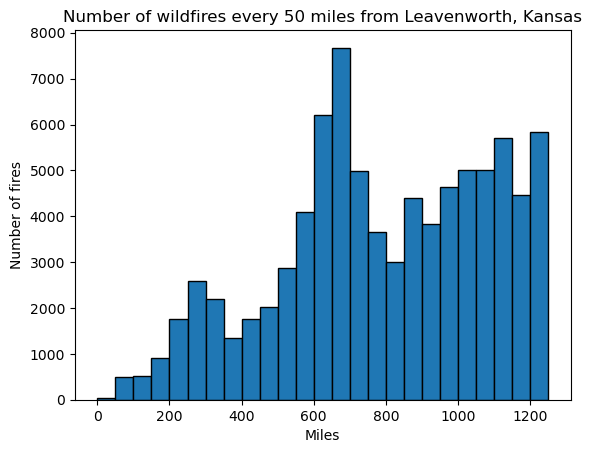

In [43]:
def histogram_number_fires(max_dist):
    '''
    Description:
        Make a matplotlib.pyplot histogram of number of fires 
        where we only consider bins of size 50
        and fires that are closer than max_dist
    Inputs:
        max_dist - Float
    '''

    #Get a list of distances
    distances = []
    for fire in wildfire_data:
        try:
            distance = fire["distance_from_Leavenworth"]
        except:
            continue
        if(distance < max_dist):
            distances.append(distance)
    
    #Set the number of bins to make them equally spaced out every 50 miles
    bins = np.linspace(0, max_dist, ((max_dist) // 50)+1)
    
    #Create plot
    plt.hist(distances, bins, edgecolor='black')
    plt.xlabel("Miles")
    plt.ylabel("Number of fires")
    plt.title("Number of wildfires every 50 miles from Leavenworth, Kansas")
    
#Create visualization
histogram_number_fires(1250)

# 9. Create time series showing annual acres burned by wildfires within 1250 miles of Leavenworth.

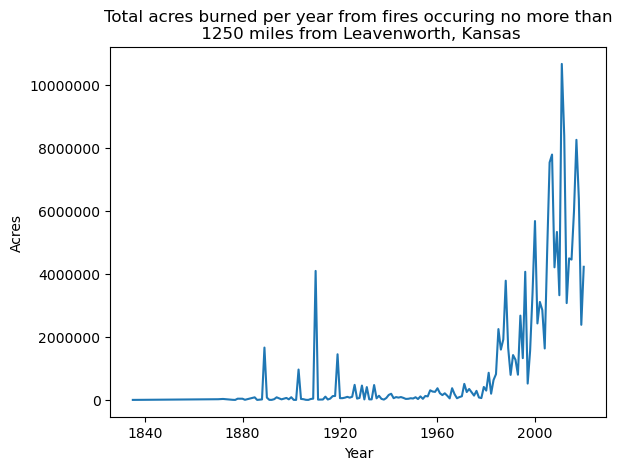

In [44]:
def time_series_totalacres(max_distance):
    """
    Description:
        Creates a time series graph showing annual acres burned by wildwires
        within a specific distance of Leavenworth
    Inputs:
        max_distance - float
    """
    dates = []
    acres_burned = []
    
    #Get years sorted
    years = []
    for year in fires_grouped_by_year:
        years.append(year)
    years.sort()
    
    #For each year...
    for year in years:
        #Get all fires
        fires = fires_grouped_by_year[year]
        
        #Store full date string that should be in format dd/mm/yyyy
        dates.append("01/01/"+ str(year))
        
        #For all fires, sum the number of burned acres if the fire is in range
        total_acres_burned = 0
        for fire in fires:
            if("distance_from_Leavenworth" in fire.keys()):
                distance = fire["distance_from_Leavenworth"]
                if(distance < max_distance):
                    total_acres_burned += fire["attributes"]["GIS_Acres"]
        #Store number of acres burned that year
        acres_burned.append(total_acres_burned)
    
    #Convert datestrings to datetime so the time series plot works
    dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
    
    #Plot
    plt.plot(dates, acres_burned)
    plt.ticklabel_format(style='plain', useOffset=False, axis='y')
    plt.xlabel("Year")
    plt.ylabel("Acres")
    plt.title("Total acres burned per year from fires occuring no more than\n " + str(max_distance) + " miles from Leavenworth, Kansas")

# Create visualization
time_series_totalacres(1250)

# 10. Create time series showing smoke estimate, create time series showing AQI estimate.

Text(0.5, 1.0, 'Time series of smoke impact estimate Leavenworth, Kansas')

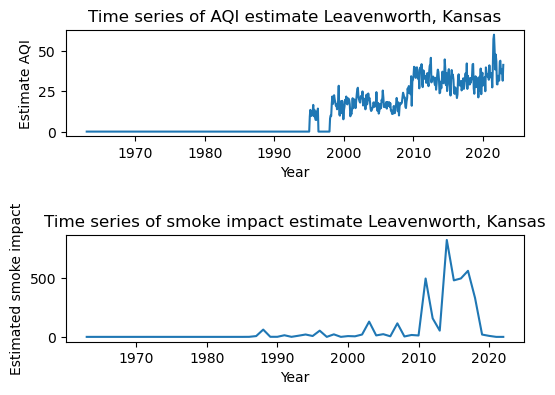

In [47]:
# Get sorted annual dates in datetime format (Just years)
smoke_estimates = []
dates = []
for year in annual_smoke_estimates.keys():
    dates.append("01/01/"+ str(year))
    smoke_estimates.append(annual_smoke_estimates[year]['total_smoke_volume_estimate'])
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

#Get sorted monthly dates in datetime format (years and months)
dates2 = []
aqi_estimates_list = []
for date in aqi_estimates.keys():
    year = date[0:4]
    month = date[4:6]
    day = "01"
    date_str = month + "/" + day + "/" + year
    dates2.append(date_str)
    aqi_estimates_list.append(aqi_estimates[date])
dates2 = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates2]

#Create 2x1 grid of plots
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=5.0)

#Plot time series of aqi estimates
ax[0].plot(dates2, aqi_estimates_list)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Estimate AQI")
ax[0].set_title("Time series of AQI estimate Leavenworth, Kansas")

#Plot time series of Smoke estimates
ax[1].plot(dates, smoke_estimates)
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Estimated smoke impact")
ax[1].set_title("Time series of smoke impact estimate Leavenworth, Kansas")